# Investigation 02: Spreading Factor Assignment Strategy with Forced Datarate Enhancement

### Authors : Luiz (UFJF), Álvaro (UFJF), Jessika (UFRN), Vicente Sousa (UFRN)

**Targets:**
- HOWTO material to download, configure and compile the code;
- HOWTO material to create, run and plot simulations results (including Python scripts);
- Preliminaly analyses of simulation results.


# Getting started


### Download Process

- To download this repository, please, type in the terminal:

```bash
git clone https://github.com/vicentesousa/ns-3-lora-gppcom.git
```

- To go to the code directory, please, type:

```bash
cd ns-3-lora-gppcom/ns-allinone-3.29/ns-3.29/
```
- To configure, type:

```bash
CXXFLAGS="-Wall -g -O0" ./waf --build-profile=debug --disable-examples --disable-tests --disable-python configure
```

- To compile, type:

```bash
./waf
```

The code for this specific study is in **ns-new-implementation** folder.

# Simulation Campaings (creation, run and plot)

Our processo to create, run and plot a simulation campaign is completely based on **yaml** files. In this file, a set of parameters is definied as well as the target parameter to a **parametric evaluation**. Such parametric evaluation allows for the analyses of the LoRaWAN metrics in function of the defined range of the target parameter.

The **yaml** file will be used by to Python functions: the **plotScript.py**, which generates all auxiliary files to run simulations; and **plotScript.py**, which plots the simulation results.

Herein, we provide two campaigns we used to perform the proof-of-concept simulations of our ADR proposal. They are:

- **nDevices** campaign with the following parameters:
   - nDevices (target parameter): 1000, 2000, 3000, 4000, 5000, 6000;
   - radius: 3000

- **radius** campaign with the following parameters:
   - radius (target parameter): 2000, 4000, 6000, 8000, 10000;
   - nDevices: 3000 

**Attention**: maybe you need to specify the **ns3_path** (with our complete path) to run simulation in our local machine.


### Campaign Criation

To configure the simulation campaign and create **ADR_campaign.yaml** file, run the following code: 

In [1]:
%%file ADR_campaign2.yaml
scenario:
    # Output filename
    filename: CampaignLoraWAN
    # Set location of simulation: local or cluster
    simLocation: local
    # Set campaign scenario: a name of one valid parameter
    #campaignX: name of parameter to vary in the X-axis
    #campaignLines: name of parameter to vary in different lines
    campaignX: 
        - radius
        - nDevices
    campaignLines: 
        - targetRealocation
    # Number of jobs to run
    jobs: 1
    # Simulation duration (seconds)
    simulationTime: 600
    # Number of end devices to include in the simulation
    nDevices:
        - 3000
        - 1000
        - 6000
    # The radius of the area to simulate
    radius: 
        - 3000
        - 8000
        - 10000
    # The radius of the area to simulate
    targetRealocation: 
        - 0
        - 5
        - 10
        - 20
        - 50
        - 60
        - 80
        # The period in seconds to be used by periodically transmitting applications
    appPeriodSeconds: 600
    # Whether or not to print various informations
    bPrint: false
    # Fixed seed and run seed (set false for a long simulation campaign)
    fixedSeed: false
    # Algoritmo de ADR: 1 to 7
    Algoritmo: 
        - 7
    # Complete path of ns-3 simulator
    ns3_path: ns-new-implementation/ns-3.29
    # Script with the main code (inside scratch folder without .cc)
    ns3_script: ADR_code

Overwriting ADR_campaign2.yaml


A seguinte função em python foi criada para, de posse do arquivo **yaml**, criar um arquivo **.sh** para rodar a campanha de simulação.  Ao executar esse código no Jupyter Notebook (Shift+Enter), o arquivo **loraScript.py** é gerado.

In [2]:
%%file loraScriptRealoc.py
from collections import defaultdict
import os
import math
import random
import re
import subprocess
import sys
import argparse
from glob import glob
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
# To install YAML: sudo apt-get install python3-yaml
import yaml

class Simulation:
    def __init__(self, configurations_file):
        #self.email_to = 'sicrano@gmail.com'            
        with open(configurations_file, 'r') as f:
            self.doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
        self.campaign_name = os.path.splitext(configurations_file)[0]
        
        # Read commom parameters
        self.campaignX = self.doc['scenario']['campaignX']
        self.campaignLines = self.doc['scenario']['campaignLines'][0]
        self.simLocation = str(doc['scenario']['simLocation'])
        self.simulationTime = self.doc['scenario']['simulationTime']
        self.nDevices = self.doc['scenario']['nDevices'][0]
        self.radius = self.doc['scenario']['radius'][0]
        self.appPeriodSeconds = self.doc['scenario']['appPeriodSeconds']
        self.bPrint = (self.doc['scenario']['bPrint'])
        self.fixedSeed = (self.doc['scenario']['fixedSeed'])
        self.algoritmo = self.doc['scenario']['Algoritmo'][0]
        self.ns3_path = str(self.doc['scenario']['ns3_path'])
        self.ns3_path = os.getcwd() + '/' + self.ns3_path
        self.ns3_script = str(self.doc['scenario']['ns3_script'])
        self.nJobs = int(self.doc['scenario']['jobs'])
        self.targetRealocation  = (self.doc['scenario']['targetRealocation'])[0]
        self.filename = str(self.doc['scenario']['filename'])
        self.configurations_file = configurations_file
       
    def runCampaign(self,curCampaign):
        # Configure simulation file in accordance with campaign parameter
        sh_name = self.campaign_name + '_' + self.simLocation + '_' + curCampaign
        print(curCampaign+" campaign written in file: " 'run_%s.sh' % sh_name)
        with open('run_%s.sh' % sh_name, 'w') as f:                    
            if self.simLocation == 'cluster':
              print('To be implemented')
            else:
              f.write('#!/bin/bash\n')
              outputDir = self.ns3_path+'/results_'+self.simLocation + '_' + curCampaign
              f.write('rm -rf '+outputDir+' 2>/dev/null\n')
              f.write('mkdir -p '+outputDir+'\n')
              f.write('cp -f run_'+sh_name+'.sh'+' '+outputDir+'\n')
              f.write('cp -f '+self.configurations_file+ ' ' +outputDir+'\n')
              f.write("cd '"+self.ns3_path+"'"+"\n")
                
            for iJob in range(0, self.nJobs):
                jobRunSeed = random.randint(1, 23*10**14)
                #for iAlg in self.algoritmo:                           
                for curLine in self.doc['scenario'][self.campaignLines]:                           
                    for varParam in self.doc['scenario'][curCampaign]:
                        command = (
                        'NS_GLOBAL_VALUE="RngRun='+str(jobRunSeed)+ '" ' +
                        "./waf --run '"+self.ns3_script+
                        " --radius="+self.radius+
                        " --nDevices="+self.nDevices+
                        " --simulationTime="+self.simulationTime+
                        " --appPeriodSeconds="+self.appPeriodSeconds+
                        " --print="+self.bPrint+
                        " --fixedSeed="+str(self.fixedSeed)+
                        " --algoritmo="+self.algoritmo+
                        " --filename="+ self.filename +
                        " --outputDir='"+outputDir+"'"
                        " --"+self.campaignLines+"="+curLine+
                        " --"+curCampaign+"="+varParam+
                        "'"
                        )
                        f.write(command+' & wait\n')
                      
parser = argparse.ArgumentParser()
parser.add_argument("-f", "--file", type=str, help='Configuration File')
args = parser.parse_args()

configurations_file = args.file; 
with open(configurations_file, 'r') as f:
    doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
    campaign_name = os.path.splitext(configurations_file)[0]

print('Simulação escolhida: ')
campaign = doc['scenario']['campaignX']
print(campaign)
                 
simu = Simulation(configurations_file)

for simC in campaign:
    if str(simC) == 'nDevices' or str(simC) == 'radius' or str(simC) == 'targetRealocation':
        simu.runCampaign(simC);
    else:
        print('Invalid simulation campaign: verify the campaign parameter!')

Writing loraScriptRealoc.py


O Script **loraScript.py** recebe um arquivo **yaml** com parâmetro de entrada e gera os segugintes arquivos:

- **run_campanha_local_nDevices.sh**: com as chamadas para as simulações variando o número de dispositivos;
- **run_campanha_local_radius.sh**: com as chamadas para as simulações variando o raio.

Esses dois arquivos **.sh** devem ser chamados em um terminal, chamando as simulações especificas de cada caso.

Abaixo, o script **loraScript.py** é chamado para a **campanha_1.yaml** criada anteriormente.


In [3]:
%run loraScriptRealoc -f "ADR_campaign2.yaml"

Simulação escolhida: 
['radius', 'nDevices']
radius campaign written in file: run_ADR_campaign2_local_radius.sh
nDevices campaign written in file: run_ADR_campaign2_local_nDevices.sh


Para rodar o código em um terminal, digite:

```python
python3 loraScript.py -f 'ADR_campaign.yaml'
```


Ao rodar o **loraScript.py** com o arquivo **campanha_1.yaml** como parâmetro, os arquivos  **run_all_campanha_1_local_nDevices.sh** e **run_all_campanha_1_local_radius.sh** foram criados. Eles contém a chamada de código para as duas campanhas de simulação especificadas em **campanha_1.yaml**.

O código a seguir executa os dois arquivos **.sh** diretamente deste Jupyter Notebook.

# Plotar gráficos 

Para plotar gráficos, chamaremos o mesmo arquivo **yaml** que foi usado para criar as campanhas de simulação. Um novo script chamado **plotScript.py** foi construído para esse fim. Ao executar esse código no Jupyter Notebook (Shift+Enter), o arquivo **plotScript.py** é gerado.

In [4]:
!chmod +x ./run_ADR_campaign2_local_radius.sh
!./run_ADR_campaign2_local_radius.sh


!chmod +x ./run_ADR_campaign2_local_nDevices.sh
!./run_ADR_campaign2_local_nDevices.sh

Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.813s)
simulation start at: Wed Feb 19 09:59:41 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 7, targetRealocation = 0, seed = 1, run stream = 3897272812, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 10:01:34 2020

Time elapsed: 1.88333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Build 

Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.799s)
simulation start at: Wed Feb 19 10:17:31 2020

Running with nDevices = 3000, radius = 8000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 7, targetRealocation = 20, seed = 1, run stream = 3897272812, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 10:19:17 2020

Time elapsed: 1.76667 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Build

Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.759s)
simulation start at: Wed Feb 19 10:35:14 2020

Running with nDevices = 3000, radius = 10000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 7, targetRealocation = 80, seed = 1, run stream = 3897272812, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/results_local_radius
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 10:36:58 2020

Time elapsed: 1.73333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Buil

Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.784s)
simulation start at: Wed Feb 19 11:06:15 2020

Running with nDevices = 3000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 7, targetRealocation = 20, seed = 1, run stream = 3020745995, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 11:08:02 2020

Time elapsed: 1.78333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Bui

simulation finished at: Wed Feb 19 11:37:12 2020

Time elapsed: 1.78333 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Waf: Leaving directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Build commands will be stored in build/compile_commands.json
'build' finished successfully (1.779s)
simulation start at: Wed Feb 19 11:37:14 2020

Running with nDevices = 1000, radius = 3000 m, simulation Time =600 s, appPeriodSeconds = 600 s, Algoritmo ADR = 7, targetRealocation = 80, seed = 1, run stream = 3020745995, outputDir = /home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/results_local_nDevices
Completed configuration
Running simulation...
Computing performance metrics...
simulation finished at: Wed Feb 19 11:37:20 2020

Time elapsed: 0.1 minutes
Waf: Entering directory `/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/build'
Waf: Leaving directory `/home

In [1]:
%%file plotScriptRealoc.py
#%%file plotScriptRealoc.py
# Legend
#   RunSeed: 0
#   Seed: 1
#   Algoritmo: 2
#   Radius: 3
#   nDevices: 4
#   appPeriodSeconds:5
#   simulationTime:6
#   PHYTotal: 7
#   PHYSuccessful:8 
#   PHYInterfered: 9
#   PHYNoMoreReceivers: 10
#   PHYUnderSensitivity: 11
#   PHYLostBecauseTX: 12
#   SimulationDuration: 13

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
import scipy.stats as st
import os
import argparse
import yaml
import matplotlib
from random import randint   
import itertools      

class openSimulation:
    def __init__(self, configurations_file):
        self.email_to = 'fulano@gmail.com'            
        with open(configurations_file, 'r') as f:
            self.doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
        self.campaign_name = os.path.splitext(configurations_file)[0]
        
        # Read commom parameters
        self.showPlot = True;
        self.plotCI = True;                
        self.campaignX = self.doc['scenario']['campaignX']
        self.campaignLines = self.doc['scenario']['campaignLines'][0]
        self.simLocation = str(doc['scenario']['simLocation'])
        self.simulationTime = self.doc['scenario']['simulationTime']
        self.nDevices = self.doc['scenario']['nDevices']
        self.nDevices = list(map(float,self.nDevices))
        self.radius = self.doc['scenario']['radius']
        self.radius = list(map(float,self.radius))
        self.appPeriodSeconds = self.doc['scenario']['appPeriodSeconds']
        self.bPrint = (self.doc['scenario']['bPrint'])
        self.fixedSeed = (self.doc['scenario']['fixedSeed'])
        self.Algoritmo = self.doc['scenario']['Algoritmo']
        self.ns3_path = str(self.doc['scenario']['ns3_path'])
        self.ns3_path = os.getcwd() + '/' + self.ns3_path
        self.ns3_script = str(self.doc['scenario']['ns3_script'])
        self.nJobs = int(self.doc['scenario']['jobs'])
        if self.nJobs == 1: # disable the confidence interval
            self.plotCI = False;
        self.filename = str(self.doc['scenario']['filename'])
        self.targetRealocation  = self.doc['scenario']['targetRealocation']
        
    def doLabelAlgoritmo(self, algID):
        # Define labels for plots legends
        if algID == '1':
            return "SF7 (I)"
        elif algID == '2':
            return "Equal Split (II)"
        elif algID == '3':
            return "Unequal Split (III)"
        elif algID == '4':
            return "Product-based (IV)"
        elif algID == '5':
            return "Proposed ADR (V)"
        elif algID == '6':
            return "Random ADR (VI)"
        elif algID == '7':
            return "ADR Realocation (VII)"
            
    def doLabeltargetRealocation(self, realocRate):
        # Define labels for plots legends
        return "Real. = "+realocRate+" %"
        
    def plotCampaign(self,curCampaign, metric):
        # some general configurations
        outputDir = self.ns3_path+'/results_'+self.simLocation + '_' + curCampaign        
        chFile = outputDir+ "/" + self.filename + '.txt'        
        print(chFile)
        simTime = np.loadtxt(chFile, skiprows=1, usecols=(6, ), delimiter=',', unpack=False)                
        resAlgoritmo = np.loadtxt(chFile, skiprows=1, usecols=(2, ), delimiter=',', unpack=False)
        restargetRealocation = np.loadtxt(chFile, skiprows=1, usecols=(14, ), delimiter=',', unpack=False)
        resradius = np.loadtxt(chFile, skiprows=1, usecols=(3, ), delimiter=',', unpack=False)
        resnDevices = np.loadtxt(chFile, skiprows=1, usecols=(4, ), delimiter=',', unpack=False)
        ressimDur = np.loadtxt(chFile, skiprows=1, usecols=(13, ), delimiter=',', unpack=False)
        resphyTotal = np.loadtxt(chFile, skiprows=1, usecols=(7, ), delimiter=',', unpack=False)
        resphySucc = np.loadtxt(chFile, skiprows=1, usecols=(8, ), delimiter=',', unpack=False)
        markers_on_all = cycle(list(itertools.product([0], [1,2,3,4,5])))
        markersA = cycle(('o', 'v', 'D', '>', 'h', '^', '*', '>', 's', 'H', 'D', 'd'))
        colors = cycle(('b', 'g', 'r', 'c', 'm', 'y', 'k'))                    
        plt.figure()     
        #for iAlg in self.algoritmo:
        for curLine in self.doc['scenario'][self.campaignLines]: 
            m_plr, m_plrCI, m_tput, m_tputCI, m_pkt, m_pktCI = [], [], [], [], [], []
            color=next(colors)
            marker=next(markersA)
            markers_on=next(markers_on_all)
            #label = self.doLabel(iAlg)            
            label = eval('self.doLabel'+self.campaignLines+'(str(curLine))')
            # Current values of line metrics'
            curMetricLine = eval('res'+self.campaignLines)
            resxData = eval('sorted(self.'+curCampaign+',key=int)')             
            
            for varParam in sorted(self.doc['scenario'][curCampaign],key=int):                
                
                # Current values of y-axis metrics
                curMetricAxis = eval('res'+curCampaign)
                resalgIndexs = (curMetricLine == int(curLine)) & (curMetricAxis == int(varParam))                
                                
                if str(curCampaign) == 'radius':
                    #resalgIndexs = (resalg == int(iAlg)) & (resradius == int(varParam))
                    xlabel='Distância [m]'
                    #resxData = sorted(self.radius,key=int) 
                #    label = self.doLabel(iAlg)
                elif str(curCampaign) == 'nDevices':
                #    resalgIndexs = (resalg == int(iAlg)) & (resnDevices == int(varParam))                    
                    xlabel='Quantidade de Dispositivos'
                #    resxData = sorted(self.nDevices,key=int)
                #    label = self.doLabel(iAlg)
                elif str(curCampaign) == 'targetRealocation':
                #    resalgIndexs = (resalg == int(iAlg)) & (restargetRealocation == int(varParam))                    
                    xlabel='Taxa de realocação [%]'
                #    resxData = self.targetRealocation
                                        
                # Plr Evaluation
                if metric=='PLR':                
                    # Calculate PLR line
                    plr = 100*( resphyTotal[resalgIndexs]-resphySucc[resalgIndexs] ) / resphyTotal[resalgIndexs]
                    m_plr = np.append(m_plr, np.mean(plr))
                    # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                    l, h = st.t.interval(0.95, len(plr)-1, loc=np.mean(plr), scale=st.sem(plr))
                    #l,h = st.norm.interval(0.95, loc=np.mean(plr), scale=st.sem(plr))                                                            
                    m_plrCI = np.append(m_plrCI, h)
                elif metric=='Tput':
                    # TODO
                    # Calculate PLR line
                    tput = 23*( resphySucc[resalgIndexs] ) / float(self.simulationTime)
                    m_tput = np.append(m_tput, np.mean(tput))
                    # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                    l, h = st.t.interval(0.95, len(tput)-1, loc=np.mean(tput), scale=st.sem(tput))
                    #l,h = st.norm.interval(0.95, loc=np.mean(tput), scale=st.sem(tput))                    
                    m_tputCI = np.append(m_tputCI, h)
                elif metric=='Pkt':
                    # TODO
                    # Calculate PLR line
                    pkt = 100 * ( resphySucc[resalgIndexs] ) / resphyTotal[resalgIndexs]
                    m_pkt = np.append(m_pkt, np.mean(pkt))
                    # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                    l, h = st.t.interval(0.95, len(pkt)-1, loc=np.mean(pkt), scale=st.sem(pkt))
                    #l,h = st.norm.interval(0.95, loc=np.mean(pkt), scale=st.sem(pkt))                    
                    m_pktCI = np.append(m_pktCI, h)

                
            # Plot line
            if metric=='PLR':                         
                plt.plot(resxData,m_plr, label=label, marker=marker,color=color,markevery=markers_on)   
                if bool(self.plotCI):
                    plt.errorbar(resxData,m_plr, yerr=(m_plrCI-m_plr), color=color, ls = 'none', marker=marker, lw = 2, capthick = 2,markevery=markers_on)
            elif metric=='Tput':
                # TODO
                plt.plot(resxData,m_tput, label=label, marker=marker,color=color,markevery=markers_on)    
                if bool(self.plotCI):                
                    plt.errorbar(resxData,m_tput, yerr = (m_tputCI-m_tput), marker=marker,color=color, ls = 'none', lw = 2, capthick = 2,markevery=markers_on)
            elif metric=='Pkt':
                # TODO
                plt.plot(resxData,m_pkt, label=label, marker=marker,color=color,markevery=markers_on)    
                if bool(self.plotCI):                
                    plt.errorbar(resxData,m_pkt, yerr = (m_pktCI-m_pkt), marker=marker,color=color, ls = 'none', lw = 2, capthick = 2,markevery=markers_on)
            
        # Plot figure
        params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
        plt.rcParams.update(params)        
        os.makedirs(outputDir+"/ps", exist_ok=True)
        os.makedirs(outputDir+"/png", exist_ok=True)
        
        if metric=='PLR':        
            # Show and save PLR plot
            ylabel="PLR [%]"
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.legend(loc='best', numpoints=1) 
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            #plt.tight_layout()
            if bool(self.plotCI):
                imgfilename = 'PLR_CI_'+curCampaign
            else:
                imgfilename = 'PLR_'+curCampaign
            plt.savefig(outputDir+"/png/"+imgfilename+".png")
            plt.savefig(outputDir+"/ps/"+imgfilename+".eps")
            if bool(self.showPlot):
                plt.show()
            else:
                plt.close()
                
        elif metric=='Tput':
            # TODO
            # Show and save PLR plot
            ylabel="Tput [bps]"
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.legend(loc='best', numpoints=1)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            #plt.tight_layout()
            if bool(self.plotCI):
                imgfilename = 'TPUT_CI_'+curCampaign
            else:
                imgfilename = 'TPUT_'+curCampaign    
            plt.savefig(outputDir+"/png/"+imgfilename+".png")
            plt.savefig(outputDir+"/ps/"+imgfilename+".eps")       
            if bool(self.showPlot):
                plt.show()
            else:
                plt.close()

        elif metric=='Pkt':
            # TODO
            # Show and save PLR plot
            ylabel="Pacotes recebidos [%]"
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.legend(loc='upper left', numpoints=1)        
            #plt.legend(loc='best', numpoints=1)        
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            #plt.tight_layout()
            if bool(self.plotCI):
                imgfilename = 'PKT_CI_'+curCampaign
            else:
                imgfilename = 'PKT_'+curCampaign    
            plt.savefig(outputDir+"/png/"+imgfilename+".png")
            plt.savefig(outputDir+"/ps/"+imgfilename+".eps")       
            if bool(self.showPlot):
                plt.show()
            else:
                plt.close()

parser = argparse.ArgumentParser()
parser.add_argument("-f", "--file", type=str, help='Configuration File')
args = parser.parse_args()

configurations_file = args.file; 
with open(configurations_file, 'r') as f:
    doc = yaml.load(f, Loader=yaml.loader.BaseLoader)
    campaign_name = os.path.splitext(configurations_file)[0]

# print(doc)
print('Simulação escolhida: ')
campaign = doc['scenario']['campaignX']
print(campaign)
                 
simu = openSimulation(configurations_file)
for iMet in ['PLR', 'Tput', 'Pkt']:
    for simC in campaign:
        if str(simC) == 'nDevices' or str(simC) == 'radius' or str(simC) == 'targetRealocation':
            simu.plotCampaign(simC,iMet);
        else:
            print('Invalid simulation campaign: verify the campaign parameter!')

Overwriting plotScriptRealoc.py


A seguir, o script **plotScript.py** é chamado para plotar os gráficos da outra campanha de simulações criada anteriormente (**campanha_2.yaml**). Como mais de 1 job foi simulado, as figuras mostram o intervalo de confiança para 95% confiança, significando que ao executar o mesmo experimento, a média estará dentro de intervalo informado em 95% das vezes. 

Simulação escolhida: 
['radius', 'nDevices']
/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/results_local_radius/CampaignLoraWAN.txt


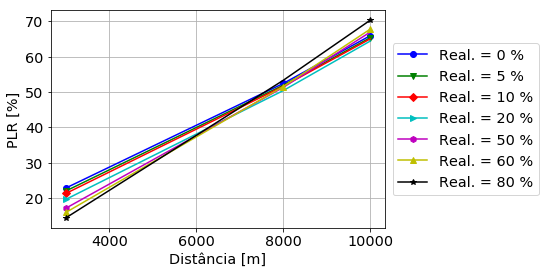

/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/results_local_nDevices/CampaignLoraWAN.txt


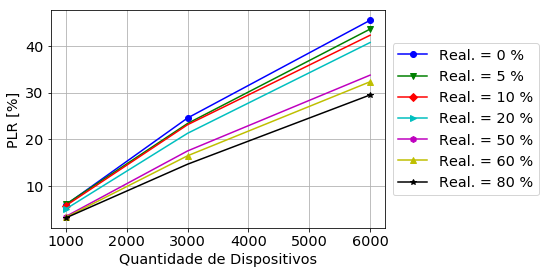

/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/results_local_radius/CampaignLoraWAN.txt


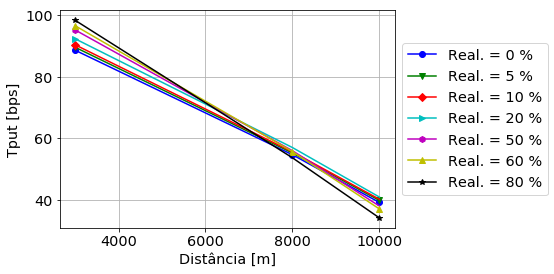

/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/results_local_nDevices/CampaignLoraWAN.txt


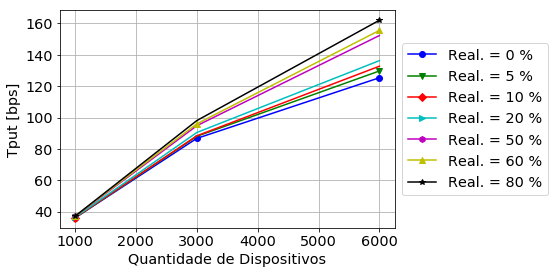

/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/results_local_radius/CampaignLoraWAN.txt


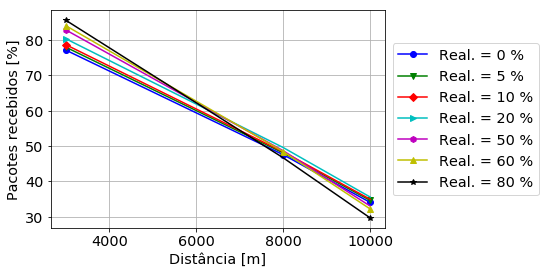

/home/simulacao/vicente/ns-3-lora-gppcom/ns-new-implementation/ns-3.29/results_local_nDevices/CampaignLoraWAN.txt


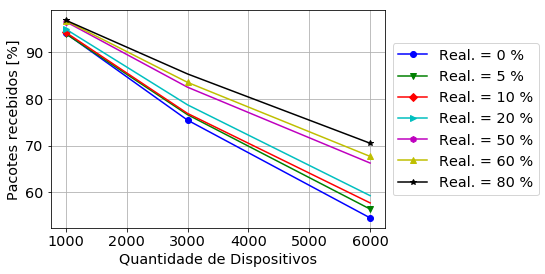

In [3]:
%run plotScriptRealoc -f "ADR_campaign2.yaml"

É possível abservar que o intervalo de confiana já é bem pequeno para 10 jobs.